In [3]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 8.0 MB/s eta 0:00:00


In [4]:
!pip install --upgrade tensorflow tensorflow_io


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [5]:
import tensorflow_io as tfio

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
# !pip install --upgrade tensorflow-io

In [7]:
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
NOT_CAPUCHINBIRD = os.path.join('/content/drive/MyDrive/data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [8]:
CAPUCHIN_FILE

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC3776-3.wav'

### Build Dataloading Function

In [9]:
def load_wav_mono(filename):
  #load the encoded wav file
  file_contents = tf.io.read_file(filename)
  #decoded wav (tensors by channels)
  wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
  #removes trailing axis
  wav = tf.squeeze(wav,axis=-1)
  sample_rate = tf.cast(sample_rate,dtype=tf.int64)
  #goes from 44100HZ to 16000hz - amplitute of the audio signal
  wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav

Plot Wave

In [10]:
wave = load_wav_mono(CAPUCHIN_FILE)
nwave = load_wav_mono(NOT_CAPUCHINBIRD)

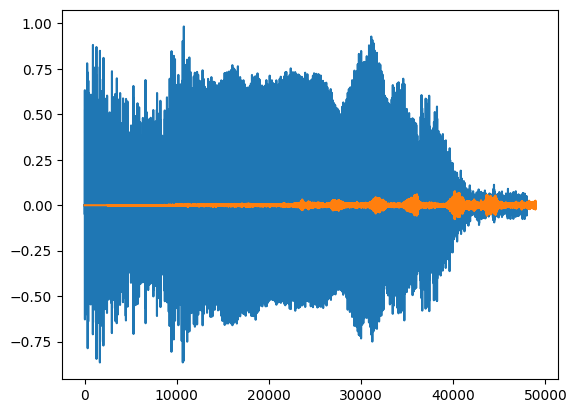

In [33]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

### Create Tensorflow Dataset

In [12]:
#define paths to positive and negative data

POS = os.path.join("/content/drive/MyDrive/data",'Parsed_Capuchinbird_Clips')

NEG = os.path.join("/content/drive/MyDrive/data",'Parsed_Not_Capuchinbird_Clips')

In [13]:
POS

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips'

Create Tensorflow Datasets

In [14]:
pos = tf.data.Dataset.list_files("/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips"+'/*.wav')

neg = tf.data.Dataset.list_files("/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips"+'/*.wav')

In [16]:
positives = tf.data.Dataset.zip(pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))

negatives = tf.data.Dataset.zip(neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))

data = positives.concatenate(negatives)

In [34]:
data = data.take(400)

In [35]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC216012-4.wav', 1.0)

### Determine The Average Length of Capuchin Call

In [27]:
lengths = []

for file in os.listdir(os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_mono(os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [36]:
lengths[:4]

[64000, 64000, 56000, 56000]

### Lets Calculate Mean,Min,Max

In [37]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [38]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [39]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Build Preprocessing Function to Convert to Spectrogram

In [78]:
def preprocess(file_path,label):
  wav = load_wav_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram,axis=2)
  return spectrogram, label

In [51]:
tf.shape(wav)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([48000], dtype=int32)>

In [63]:
wav = load_wav_mono('/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC16803-2.wav')
wav = wav[:48000]
zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
wav = tf.concat([zero_padding,wav],0)

In [74]:
spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram,axis=2)

In [76]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[8.2712297e+00],
        [1.1763720e+01],
        [1.1554960e+01],
        ...,
        [1.5684971e-05],
        [3.3513079e-05],
        [5.0544739e-05]],

       [[1.5480854e+01],
        [1.5295379e+01],
        [1.1863073e+01],
        ...,
        [9.6986281e-05],
        [5.2948253e-05],
        [2.3841858e-06]],

       [[1.9895573e+01],
        [1.7814072e+01],
        [1.2153693e+01],
        ...,
        [1.9551777e-05],
        [5.7325662e-05],
        [2.0027161e-05]],

       ...,

       [[1.3732693e+01],
        [1.2159479e+01],
        [7.6007237e+00],
        ...,
        [6.7857736e-06],
        [6.0046583e-05],
        [2.0980835e-05]],

       [[9.2061653e+00],
        [9.7071152e+00],
        [7.7989798e+00],
        ...,
        [1.6271959e-05],
        [5.3490843e-05],
        [1.4781952e-05]],

       [[3.6183498e+00],
        [7.3975191e+00],
        [7.8667340e+00],
        ...,
        [4.4163462

### Test Out The Function And Viz The Spectrogram

In [79]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

spectrogram, label = preprocess(filepath, label)

In [80]:
len(spectrogram)

1491

In [82]:
# tf.transpose(spectrogram)[0]

<tf.Tensor: shape=(257, 1491), dtype=float32, numpy=
array([[1.07474521e-01, 3.68928686e-02, 4.20072973e-02, ...,
        2.72040814e-02, 3.44390683e-02, 3.55095491e-02],
       [6.30209371e-02, 3.69986184e-02, 4.00220528e-02, ...,
        3.21563892e-02, 3.13255601e-02, 2.62876656e-02],
       [8.46436545e-02, 4.01869789e-02, 4.16148566e-02, ...,
        4.12529781e-02, 3.35960723e-02, 1.77642033e-02],
       ...,
       [2.91905690e-05, 1.03278880e-05, 2.38817192e-05, ...,
        5.28116288e-05, 5.86324495e-05, 4.43240315e-05],
       [2.28496101e-05, 3.54918338e-05, 5.80257483e-06, ...,
        2.10074431e-05, 2.52662849e-05, 1.45572540e-05],
       [5.41284680e-06, 2.78279185e-05, 4.14252281e-06, ...,
        1.41859055e-05, 6.69434667e-06, 1.37463212e-05]], dtype=float32)>

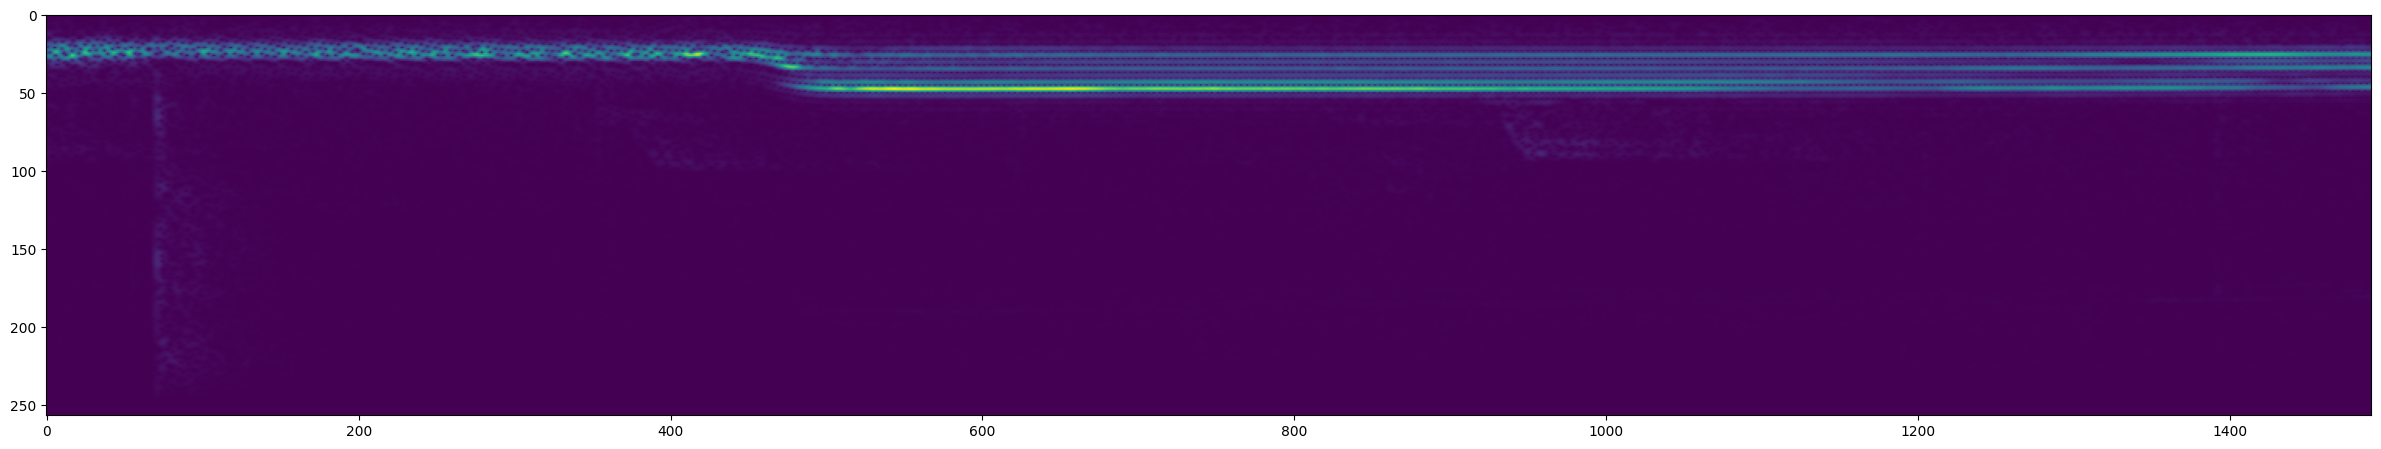

In [81]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Create Training and Testing Partitions


Create a Tensorflow Data Pipeline

In [83]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### Split into Training and Testing Partions

In [90]:
len(data)

25

In [84]:
len(data)*.7

17.5

In [91]:
train = data.take(18)
test = data.skip(18)

In [92]:
len(train),len(test)

(18, 7)

### Test One Batch

In [93]:
sample,label = train.as_numpy_iterator().next()

In [96]:
sample[0][0].shape

(257, 1)

### Build Deep Learning Model

Load Tensorflow Dependencies

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten

### Build Sequential Model, Compile and View Summary

In [97]:
model = Sequential([
    Conv2D(16,(3,3),activation='relu',input_shape=(1491,257,1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1,activation='sigmoid')
])

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 flatten (Flatten)           (None, 6075120)           0         
                                                                 
 dense (Dense)               (None, 128)               777615488 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 777615777 (2.90 GB)
Trainable params: 777615777 (2.90 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
